## PHASE3 PROJECT
NAME : Hanifa Chepchirchir

Project Title: Predicting Customer Churn

COURSE : DSFT-12

FACILITATOR : Nikita Njoroge

 ### Business Understanding
 
 SyriaTel is losing nearly 15% of its customers every year to competitors. With rising acquisition costs and intense market competition, understanding why customers churn—and who is likely to churn—has never been more critical. This project uses data-driven insights to identify churn risks early and help SyriaTel retain valuable customer
##### Objective:
SyriaTel is facing customer churn, which directly impacts revenue. The Customer Retention and Marketing Team wants to understand and predict which customers are most likely to churn.

##### Goal:
Build a classification model that predicts whether a customer will churn using features like service usage, international plan status, voicemail activity, and customer support interactions.

      Key Questions to Answer:

              Can we predict churn based on customer behavior?

              What are the most influential features in predicting churn?

              How can SyriaTel use these insights to reduce churn?

### Data Understanding
##### Data Source:
SyriaTel’s customer service usage dataset.

Description of Data:
Includes numerical and categorical features related to customer activity:

Account length

International and voicemail plans

Call durations, counts, and charges for day/evening/night/international

Number of customer service calls

Target: Churn (1 = Yes, 0 = No)

Initial Observations:

Data appears clean and ready for preprocessing

Target is binary and suitable for classification

Categorical variables already encoded



### Data Preparation

##### Steps Taken:


Data Quality Checks

Verify the dataset for missing values, nulls, and duplicates .

Check for outliers using visualizations (e.g., boxplots) and summary statistics.

Data Type Validation

Ensure all columns had the correct data types:

Categorical: international plan, voice mail plan, churn

Numerical: call durations, call counts, charges, etc.

Convert yes/no features to binary format (e.g., international plan: yes = 1, no = 0).

Feature Engineering

   Creat total charge and total call count features by aggregating across day, evening, night, and international usage.

   Derive average call duration per call type to assess intensity of use.

   Engineerer a high_service_calls flag for customers making ≥4 service calls (possible dissatisfaction indicator).

Feature Selection
Select features based on correlation analysis, domain knowledge, and importance from tree-based models:

     Usage Behavior: total day minutes, total eve minutes, total intl minutes, total call count

     Financial Signals: total day charge, total intl charge

     Service Experience: customer service calls, high_service_calls

     Plans & Messages: international plan, voice mail plan, number vmail messages

     Account Details: account length

Target Variable

churn (binary classification):

     1 = Customer Churned

     0 = Customer Stayed

Class Imbalance Handling

Churners comprised only ~14% of total data.

Use SMOTE during training to balance class distribution for fair model learning.


### imported relevant libraries

In [650]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV,StratifiedKFold
from sklearn.linear_model import LinearRegression,LogisticRegression, Ridge,Lasso
from sklearn import metrics
import statsmodels.api as sm
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, r2_score,roc_curve, auc,roc_auc_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder,StandardScaler,PolynomialFeatures,LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.tree import DecisionTreeClassifier


1. Data Loading

In [651]:
df = pd.read_csv('datasets_2667_4430_bigml_59c28831336c6604c800002a.csv') 
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


Loads the dataset and shows first 5 rows.

In [652]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

In [653]:

df.isnull().sum()
df.describe()

,account length,area code,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [654]:
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
df.head()


,state,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [655]:
# Check for duplicates
df.duplicated().sum()

# Drop any duplicates
df = df.drop_duplicates()

# Check data types
df.dtypes

# Confirm categorical features are encoded (0/1)
df[['international_plan', 'voice_mail_plan', 'churn']].head()

,international_plan,voice_mail_plan,churn
0,no,yes,False
1,no,yes,False
2,no,no,False
3,yes,no,False
4,yes,no,False


preparing some of our categorical and target variables for machine learning models by converting them into numerical formats

In [656]:
df['international_plan'] = df['international_plan'].map({'yes': 1, 'no': 0})
df['voice_mail_plan'] = df['voice_mail_plan'].map({'yes': 1, 'no': 0})
df['churn'] = df['churn'].astype(int)  


2.Data Cleaning:

removing some columns that are not useful for modeling

In [657]:
df.drop(['phone number', 'area code', 'state'], axis=1, inplace=True, errors='ignore')
print(df.columns.tolist())

['account_length', 'area_code', 'phone_number', 'international_plan', 'voice_mail_plan', 'number_vmail_messages', 'total_day_minutes', 'total_day_calls', 'total_day_charge', 'total_eve_minutes', 'total_eve_calls', 'total_eve_charge', 'total_night_minutes', 'total_night_calls', 'total_night_charge', 'total_intl_minutes', 'total_intl_calls', 'total_intl_charge', 'customer_service_calls', 'churn']


Drops unnecessary columns

Encodes categorical variables as binary

converting categorical columns into numeric format using LabelEncoder from sklearn.preprocessing.

This is necessary because most machine learning algorithms work with numbers—not strings

In [658]:
 # Encode categorical columns
le = LabelEncoder()
df["churn"] = le.fit_transform(df["churn"])
df["international_plan"] = le.fit_transform(df["international_plan"])
df["voice_mail_plan"] = le.fit_transform(df["voice_mail_plan"])

Converting the Target Variable to Binary and Checking Class Distribution

In [659]:
# Convert target variable to binary
df['churn'] = df['churn'].astype(int)
# Check class distribution
print("\nClass distribution:\n", pd.Series(y).value_counts(normalize=True))



Class distribution:
 churn
0    0.855086
1    0.144914
Name: proportion, dtype: float64


Visualizing Churn Distribution and Relationship with Customer Service Calls

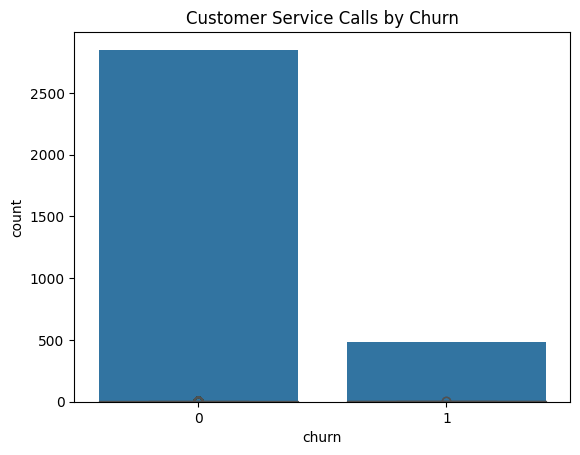

In [660]:
# Churn distribution
sns.countplot(x='churn', data=df)
plt.title("Churn Distribution")

# Compare churn vs non-churn for key features
sns.boxplot(x='churn', y='customer_service_calls', data=df)
plt.title("Customer Service Calls by Churn")
plt.show()

This plot shows the number of customers who churned (churn = 1) versus those who did not (churn = 0).

### Class Distribution Visualization:

Counting and Visualizing the Churn Classes

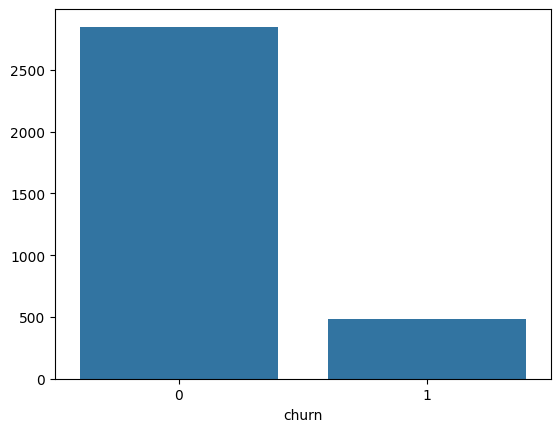

In [661]:
df['churn'].value_counts()
sns.barplot(x=df['churn'].value_counts().index, y=df['churn'].value_counts().values)
plt.show()

This line counts how many times each unique value appears in the churn column.

Since churn is a binary variable (0 = no churn, 1 = churn), it will count how many customers did not churn versus how many did.

### 3. Feature Engineering:

Creating Aggregated and Derived Variables

In [662]:
# Total minutes
df['total_minutes'] = df['total_day_minutes'] + df['total_eve_minutes'] + df['total_night_minutes']
# This creates a new feature that sums the total minutes a customer spent on calls during the day, evening, and night.
# It provides an overall measure of how much a customer uses the phone in total.

# Total calls
df['total_calls'] = df['total_day_calls'] + df['total_eve_calls'] + df['total_night_calls']
# This sums the total number of calls a customer made across all times of day.
# It gives a comprehensive count of customer call activity.

# Total charge
df['total_charge'] = df['total_day_charge'] + df['total_eve_charge'] + df['total_night_charge']
# This sums the total charges incurred by the customer for calls at all times.
# It captures the overall monetary cost of the customer’s phone usage.

# Average minutes per call
df['avg_minutes_per_call'] = df['total_minutes'] / df['total_calls']
# This calculates the average duration of calls made by the customer.
# It provides insight into how long each call typically lasts.
# Average charge per call

# Customer service calls per account length
df['service_calls_per_length'] = df['customer_service_calls'] / df['account_length']
# This calculates the ratio of customer service calls to the length of the account.
# It helps understand how frequently customers contact support relative to their account duration.


Creates aggregated features from existing ones

In [663]:
# Displaying Aggregated Features and Their Components
print(df[['total_minutes', 'total_day_minutes', 'total_eve_minutes', 'total_night_minutes']].head())
print(df[['total_charge', 'total_day_charge', 'total_eve_charge', 'total_night_charge']].head())


   total_minutes  total_day_minutes  total_eve_minutes  total_night_minutes
0          707.2              265.1              197.4                244.7
1          611.5              161.6              195.5                254.4
2          527.2              243.4              121.2                162.6
3          558.2              299.4               61.9                196.9
4          501.9              166.7              148.3                186.9
   total_charge  total_day_charge  total_eve_charge  total_night_charge
0         72.86             45.07             16.78               11.01
1         55.54             27.47             16.62               11.45
2         59.00             41.38             10.30                7.32
3         65.02             50.90              5.26                8.86
4         49.36             28.34             12.61                8.41


- The `total_minutes` column is the sum of `total_day_minutes`, `total_eve_minutes`, and `total_night_minutes` for each customer.
- Similarly, `total_charge` is the sum of charges from the day, evening, and night periods.
- These values confirm the aggregation calculations are accurate, as each total closely matches the sum of its components.
- This validation step helps ensure that the feature engineering was done correctly before using these features in analysis or modeling.


 Dropping Original Individual Time Period Columns

In [664]:
df.drop([
    'total_day_minutes', 'total_eve_minutes', 'total_night_minutes',
    'total_day_calls', 'total_eve_calls', 'total_night_calls',
    'total_day_charge', 'total_eve_charge', 'total_night_charge'
], axis=1, inplace=True)


Dropping these columns cleans up the dataset by keeping only the aggregated, more meaningful features, helpiing in analysis and modeling process.

Correlation Matrix Heatmap for Numeric Features

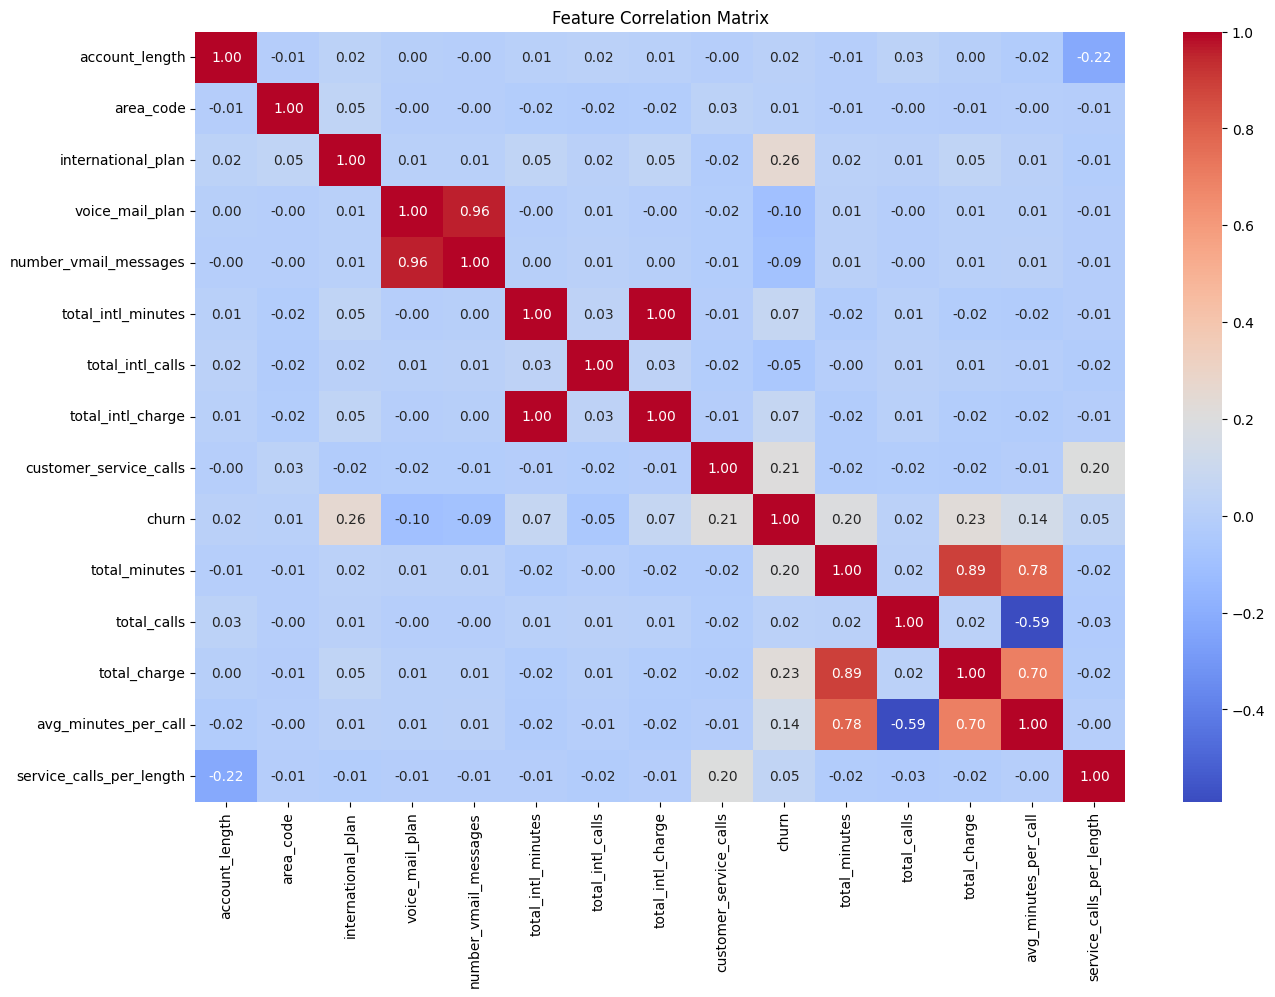

In [665]:
numeric_df = df.select_dtypes(include=['number'])
corr_matrix = numeric_df.corr()

plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()


Feature correlation helps us see how different variables in our dataset are connected. If two features have a strong positive correlation (close to 1.0), it means that when one increases, the other tends to increase too. If the correlation is negative (close to -1.0), it means that when one increases, the other decreases.
For example:
- If "total minutes" and "total charge" have a high correlation, it makes sense—more minutes mean a higher charge.
- If "customer service calls" and "churn" have a strong correlation, it might mean that customers who call frequently are likely to leave.
We use correlation to choose the best features for a machine learning model. If two features are almost identical, we can remove one to avoid redundancy. If a feature strongly relates to the target variable (like churn), it could be a key predictor.


Analyzing Churn Class Distribution and Percentage

In [666]:
y = df["churn"].value_counts()
print(f"Churn Data :\n{y}\n")

# save all the rows where churn is True
y_True = df["churn"][df["churn"] == True]
print(y_True)

print ("\nChurn Percentage = "+str( (y_True.shape[0] / df["churn"].shape[0]) * 100 ))

Churn Data :
churn
0    2850
1     483
Name: count, dtype: int64

10      1
15      1
21      1
33      1
41      1
       ..
3301    1
3304    1
3320    1
3322    1
3323    1
Name: churn, Length: 483, dtype: int64

Churn Percentage = 14.491449144914492


About 14.5% of customers in the dataset have churned, with 483 churned and 2,850 non-churned customers. This shows an imbalance in the classes, which is important to keep in mind for modeling. The churned customers are clearly identified within the dataset for further analysis.

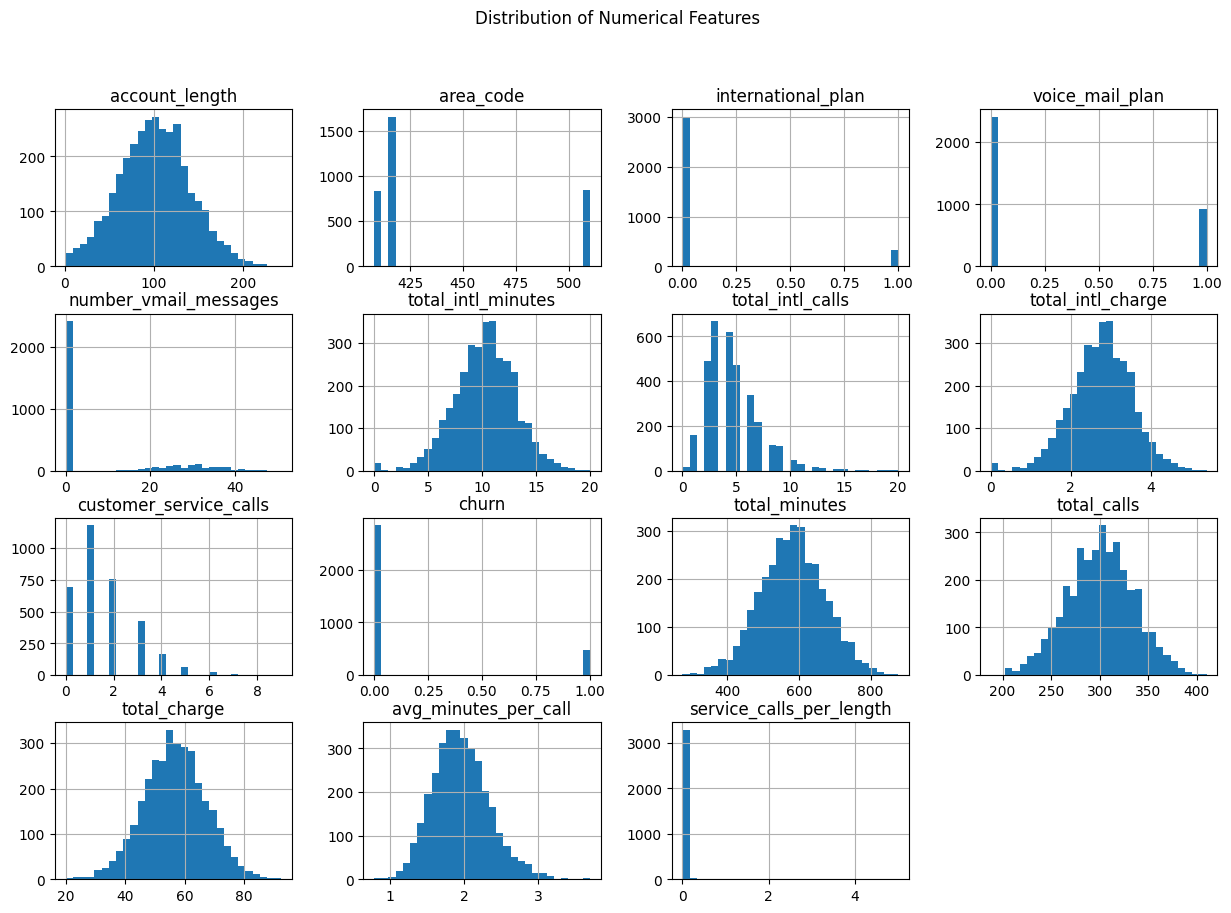

In [667]:
# Plot distribution of numerical features
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
df[numerical_cols].hist(figsize=(15, 10), bins=30)
plt.suptitle('Distribution of Numerical Features')
plt.show()

- Some distributions may be right-skewed (long tail to the right) or left-skewed, indicating potential outliers or extreme values. If a histogram has a sharp peak, it suggests concentrated values around a specific range.
- Variables like customer_service_calls and churn could show clear distinctions, helping in identifying patterns that contribute to customer attrition.
- If certain values dominate a histogram (e.g., international_plan or voice_mail_plan having mostly zeros), it suggests class imbalance, which might need handling in your churn prediction model.
- Features with wide-ranging values (like total_minutes and total_charge) might require scaling for models to perform effectively


Selecting Relevant Features for Analysis

In [668]:
df = df[["customer_service_calls","voice_mail_plan","international_plan","total_minutes","total_charge","avg_minutes_per_call","number_vmail_messages","service_calls_per_length","churn"]]
df.head()

,customer_service_calls,voice_mail_plan,international_plan,total_minutes,total_charge,avg_minutes_per_call,number_vmail_messages,service_calls_per_length,churn
0,1,1,0,707.2,72.86,2.357333,25,0.007812,0
1,1,1,0,611.5,55.54,1.858663,26,0.009346,0
2,0,0,0,527.2,59.00,1.607317,0,0.000000,0
3,2,0,1,558.2,65.02,2.250806,0,0.023810,0
4,3,0,1,501.9,49.36,1.409831,0,0.040000,0


 selects a subset of columns from the original dataframe df, keeping only the most relevant features for further analysis and modeling.

 Visualizing Key Features by Churn Status with Boxplots

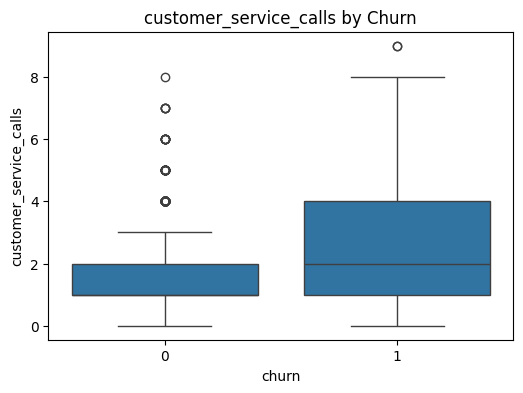

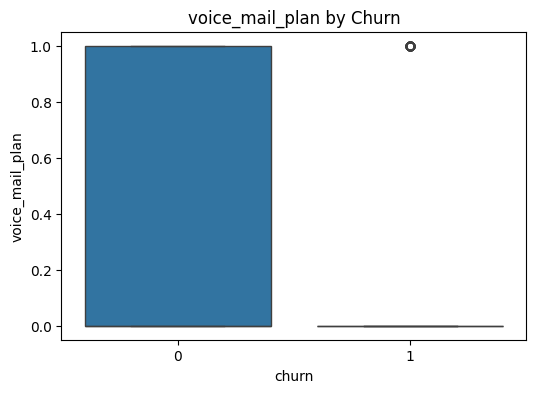

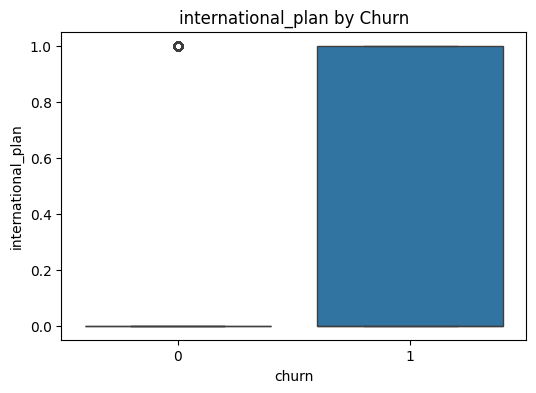

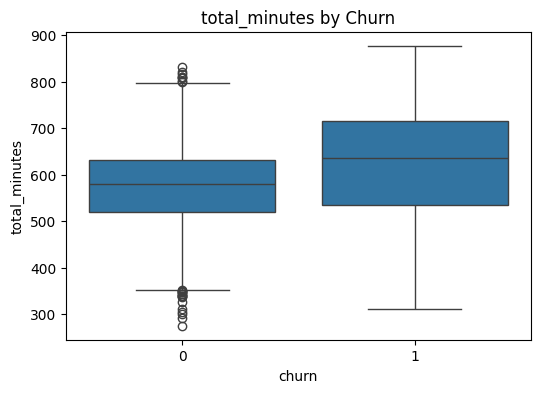

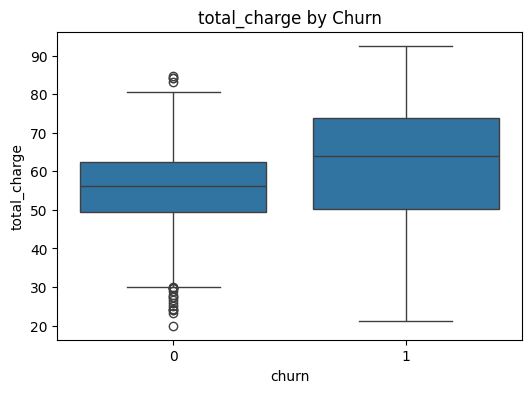

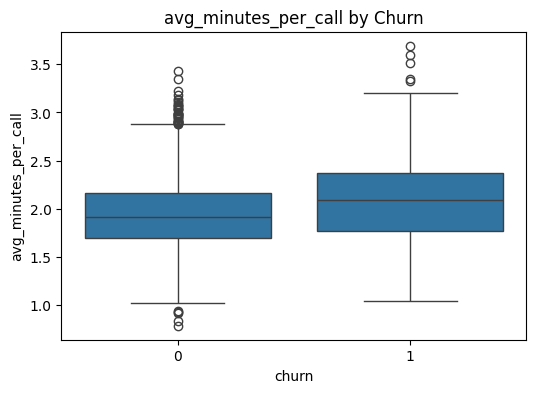

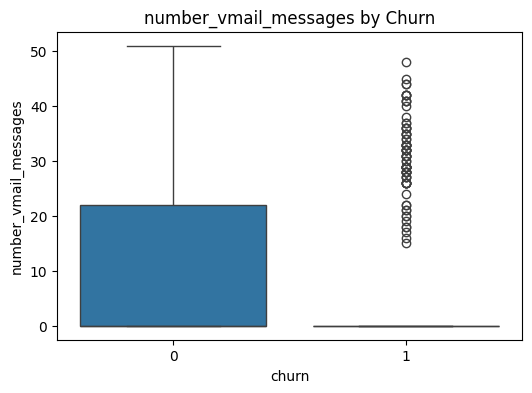

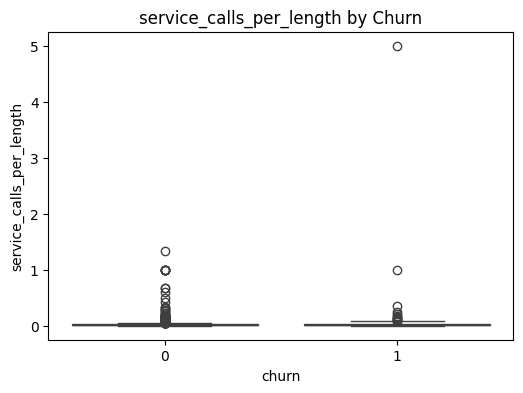

In [669]:
key_features = [
    "customer_service_calls",
    "voice_mail_plan",
    "international_plan",
    "total_minutes",
    "total_charge",
    "avg_minutes_per_call",
    "number_vmail_messages",
    "service_calls_per_length"
]
for feature in key_features:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='churn', y=feature, data=df)
    plt.title(f'{feature} by Churn')
    plt.show()




This loop iterates over a list of selected key features and creates individual boxplots comparing each feature's distribution across the two classes of the target variable churn (0 = no churn, 1 = churn).

Boxplots show the distribution summary of a feature including:

Median 

Interquartile range 

Whiskers 

Outliers 

By plotting feature values split by churn status, we can visually inspect if and how each feature differs between customers who churned versus those who didn’t.

Displaying the List of Columns in the DataFrame

In [670]:
print(df.columns.tolist())


['customer_service_calls', 'voice_mail_plan', 'international_plan', 'total_minutes', 'total_charge', 'avg_minutes_per_call', 'number_vmail_messages', 'service_calls_per_length', 'churn']


## Preparing Data for Modeling: Splitting Features and Target

In [671]:

X = df.drop("churn", axis=1)
y = df["churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Splitting data allows one to train the model on one portion (training set) and evaluate its performance on unseen data (testing set).

This helps assess how well the model generalizes to new, unseen customers

##  Identify Numeric and Categorical Columns

In [672]:
# These are numerical features relevant for churn prediction
# Separating Numerical and Categorical Features for Modeling
numeric_features = [
    'customer_service_calls',
    'total_minutes',
    'total_charge',
    'avg_minutes_per_call',
    'number_vmail_messages',
    'service_calls_per_length'
]

# These are categorical features relevant for churn prediction
possible_categoricals = ['international_plan', 'voice_mail_plan']
categorical_features = [col for col in possible_categoricals if col in df.columns]


## Preprocessing (Avoiding Data Leakage)

In [673]:
# Preprocessing Numerical and Categorical Features
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[numeric_cols])
X_test_num = scaler.transform(X_test[numeric_cols])

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_cat = encoder.fit_transform(X_train[categorical_cols])
X_test_cat = encoder.transform(X_test[categorical_cols])

X_train_final = np.hstack((X_train_num, X_train_cat))
X_test_final = np.hstack((X_test_num, X_test_cat))

preprocesses the dataset by scaling numeric features, encoding categorical features, and merging them to create the final training and testing datasets for modeling.

In [674]:
# Select numeric columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns

# Scale numeric columns
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test_scaled[numeric_features] = scaler.transform(X_test[numeric_features])

scales numerical features in both training and test sets using pandas DataFrames while maintaining data integrity and preventing data leakage.

In [675]:

# One-hot encode categorical variables
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore') 
X_train_cat = encoder.fit_transform(X_train[categorical_features])
X_test_cat = encoder.transform(X_test[categorical_features])

encodes categorical features into a machine-readable numeric format, enabling the model to effectively use categorical data during training and testing.

Scaling Numerical Features and Combining with Encoded Categorical Features

In [676]:

# Scale numeric features
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[numeric_features])
X_test_num = scaler.transform(X_test[numeric_features])

X_train_final = np.hstack([X_train_num, X_train_cat])
X_test_final = np.hstack([X_test_num, X_test_cat])

finalizes the preprocessing pipeline by scaling numeric features and concatenating them with encoded categorical features, producing clean, standardized datasets for modeling.

 Balancing the Training Data Using SMOTE

In [677]:

#  Apply SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_final, y_train)
print("Before SMOTE:", pd.Series(y_train).value_counts())
print("After SMOTE:", pd.Series(y_train_res).value_counts())

Before SMOTE: churn
0    2284
1     382
Name: count, dtype: int64
After SMOTE: churn
0    2284
1    2284
Name: count, dtype: int64


Before SMOTE
Class 0 (Not Churned): 2284 samples

Class 1 (Churned): 382 samples
> The dataset is highly imbalanced.

After SMOTE
Class 0 (Not Churned): 2284 samples

Class 1 (Churned): 2284 samples
> The dataset is now perfectly balanced.

Balances the training dataset by generating synthetic minority class examples, enhancing the model's ability to correctly classify churners and improving the robustness of the predictive model.

## Logistic Regression (Baseline Model)

In [678]:
# Logistic Regression Training and Evaluation
model = LogisticRegression(max_iter=1000)
model.fit(X_train_res, y_train_res)
y_pred = model.predict(X_test_final)
y_prob = model.predict_proba(X_test_final)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       0.95      0.77      0.85       566
           1       0.38      0.78      0.51       101

    accuracy                           0.78       667
   macro avg       0.67      0.78      0.68       667
weighted avg       0.87      0.78      0.80       667

ROC AUC Score: 0.8430885491375992



The model correctly identifies 78% of both churned and non-churned customers. It is especially good at catching churners (recall = 78%) but sometimes wrongly predicts churn (precision = 38%). Overall, the model is fairly accurate (78%) and has a strong ability to distinguish between classes (ROC AUC = 0.84).

## Xgboost Baseline model

In [679]:
# XGBoost model training and evaluation
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("XGBoost Report:\n", classification_report(y_test, y_pred_xgb))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

XGBoost Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.96       566
           1       0.85      0.70      0.77       101

    accuracy                           0.94       667
   macro avg       0.90      0.84      0.87       667
weighted avg       0.93      0.94      0.93       667

ROC AUC Score: 0.8430885491375992


The XGBoost model is highly accurate (94%) and performs well at identifying both churned and non-churned customers. It detects 70% of churners (recall) and is correct 85% of the time when it predicts a customer will churn (precision). The ROC AUC score of 0.84 shows the model has a strong ability to distinguish between churn and non-churn.

In [680]:
# Handling Class Imbalance with XGBoost
xgb = XGBClassifier(scale_pos_weight=566/101, use_label_encoder=False, eval_metric='logloss')


## Performance:
Accuracy: 0.94 (excellent overall performance)

Macro Avg F1: 0.90– balances performance across classes

Weighted Avg F1: 0.93 – influenced by the dominant class (0

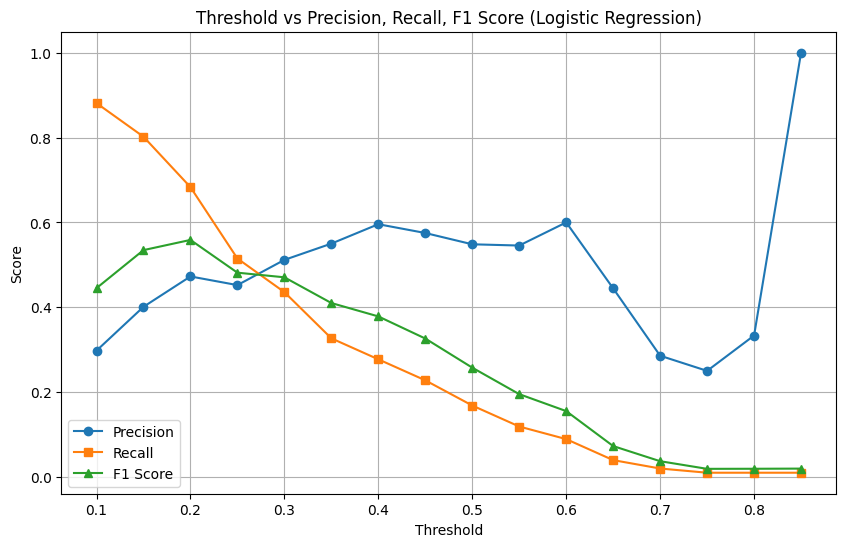

In [681]:
# Get predicted probabilities for the positive class (churn = 1)
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_prob_lr = lr.predict_proba(X_test)[:, 1]

# Define thresholds to evaluate
thresholds = np.arange(0.1, 0.9, 0.05)

# Prepare lists to store metrics
precisions, recalls, f1_scores = [], [], []

# Calculating metrics at each threshold
for t in thresholds:
    y_pred_adjusted = (y_prob_lr >= t).astype(int)
    precisions.append(precision_score(y_test, y_pred_adjusted))
    recalls.append(recall_score(y_test, y_pred_adjusted))
    f1_scores.append(f1_score(y_test, y_pred_adjusted))

# Plot precision, recall, F1 vs. threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', marker='o')
plt.plot(thresholds, recalls, label='Recall', marker='s')
plt.plot(thresholds, f1_scores, label='F1 Score', marker='^')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Threshold vs Precision, Recall, F1 Score (Logistic Regression)')
plt.legend()
plt.grid(True)
plt.show()


This feature correlation matrix shows how different features in the dataset relate to each other. Darker colors indicate stronger negative correlations, while lighter colors represent weak or no correlations. Since there are no strong positive correlations, it suggests that most features don’t have a direct, predictable relationship with each other. This means that to improve model predictions, you may need to create new combined features that better capture customer behavior.


In [682]:
# Applying the Optimal Threshold (0.23)
optimal_threshold = 0.23
y_pred_final = (y_prob_lr >= optimal_threshold).astype(int)


In [683]:
actual_churn_rate = np.mean(y_test)
print(f"Actual Churn Rate: {actual_churn_rate:.2f}")

Actual Churn Rate: 0.15


###  Comparing Actual vs Predicted Churn Rates

- **Actual Churn Rate**: **15%**  
  This is the true proportion of churners in the dataset.
- The model is **slightly more aggressive** in flagging churners, predicting churn for more customers than actually churned.
- This **intentional bias** may help reduce **false negatives** (missed churners), which is often preferable in customer retention scenarios.
- If customer retention efforts are **not too costly**, it's better to over-predict and engage a few extra loyal customers than to miss real churners.
- However, if interventions are expensive, this **higher predicted churn rate (19%)** may require careful targeting or tiered follow-up strategies.

This slight overestimation (4%) is generally acceptable, especially if the goal is to **catch as many true churners as possible.


In [684]:
# Churn Prediction Rate
churn_rate = np.mean(y_pred_final)  
print(f"Churn Prediction Rate: {churn_rate:.2f}")

Churn Prediction Rate: 0.19


### Churn Prediction Rate: 19%

The model predicts that **19%** of customers are likely to churn based on the selected threshold of **0.23**.
- Out of all customers in the test set, **19 out of every 100** are predicted to be at risk of churning.
- This rate is higher than the actual churn rate in the dataset (15%), indicating the model is slightly **more conservative**—flagging more potential churners to minimize missed cases.
- If proactive retention strategies (e.g. discounts, calls, loyalty rewards) are deployed, they should be planned for **about 1 in 5 customers**.
- This conservative approach may be useful if the **cost of losing a customer is high**, and it's better to act on more leads than miss a true churner.


In [685]:
print(classification_report(y_test, y_pred_final))

              precision    recall  f1-score   support

           0       0.93      0.88      0.90       566
           1       0.47      0.60      0.53       101

    accuracy                           0.84       667
   macro avg       0.70      0.74      0.72       667
weighted avg       0.86      0.84      0.85       667



This model achieves high accuracy (84%) and performs well at identifying non-churners, with a precision of 93% and recall of 88% for class 0. For churners (class 1), the precision is moderate at 47%, meaning many predicted churners might not actually churn, but the recall is 60%, so it correctly detects 60% of actual churners. Overall, the model balances identifying churners while maintaining good overall performance, though there is room to improve precision on the churn class.

In [686]:
from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

 This ensemble method improves accuracy by aggregating many decision trees, reducing overfitting. Using random_state=42 ensures consistent, reproducible results across runs

In [687]:
# Feature Importance from Random Forest
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(importances_df)


                    Feature  Importance
4              total_charge    0.335019
3             total_minutes    0.170860
0    customer_service_calls    0.127138
5      avg_minutes_per_call    0.110531
7  service_calls_per_length    0.088996
2        international_plan    0.070983
6     number_vmail_messages    0.057887
1           voice_mail_plan    0.038586


  This identifies total charge, total minutes, and customer service calls as the top factors influencing churn, highlighting that customers’ billing and usage patterns are the strongest predictors

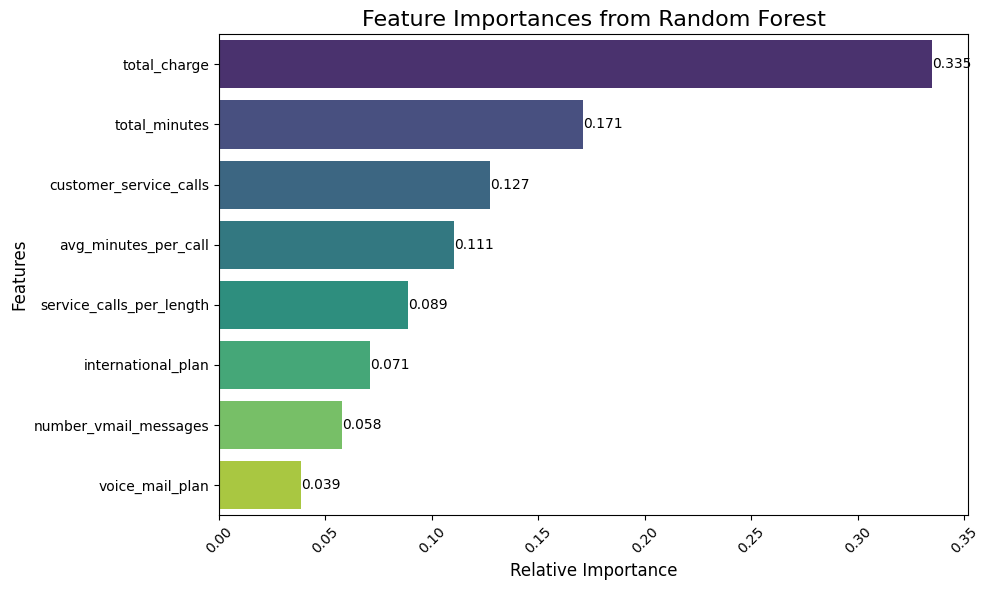

In [688]:
# Creating the plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances_df, palette='viridis')

# Customizing the plot
plt.title('Feature Importances from Random Forest', fontsize=16)
plt.xlabel('Relative Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.xticks(rotation=45)  

# Adding value labels on each bar
for index, value in enumerate(importances_df['Importance']):
    plt.text(value, index, f'{value:.3f}', va='center')

plt.tight_layout()  
plt.show()

"""Total charge is the most critical factor influencing customer churn, followed by usage patterns and customer service interactions, suggesting that pricing strategies and service quality improvements should be prioritized to reduce churn."""

In [689]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(LogisticRegression(max_iter=1000), X_train_final, y_train, cv=cv, scoring='f1')

print("Cross-Validation F1 Scores:", cv_scores)
print("Mean F1 Score:", np.mean(cv_scores))

Cross-Validation F1 Scores: [0.21276596 0.16091954 0.26666667 0.38181818 0.25454545]
Mean F1 Score: 0.2553431601413993


The cross-validation F1 scores range from 0.16 to 0.38, showing high variability that suggests inconsistent model performance across different data subsets. The average F1 score of 0.26 indicates the model struggles to effectively identify churn cases while maintaining precision. This performance likely stems from either severe class imbalance, insufficient training data, or the need for better feature engineering to improve prediction consistency.

In [690]:
# Handling Class Imbalance with SMOTE
print("Class distribution:\n", pd.Series(y).value_counts())
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


Class distribution:
 churn
0    2850
1     483
Name: count, dtype: int64


The dataset is imbalanced, with about 85% non-churners and 15% churners, which can bias models if not addressed properly.

In [691]:
# displays a list of all the feature names
print(X_resampled.columns.tolist())

['customer_service_calls', 'voice_mail_plan', 'international_plan', 'total_minutes', 'total_charge', 'avg_minutes_per_call', 'number_vmail_messages', 'service_calls_per_length']


In [692]:
# Creating New Features in the Resampled Dataset
X_resampled["tenure_estimate"] = X_resampled["total_minutes"] / (X_resampled["total_charge"] + 1e-6)
X_resampled["engagement_score"] = X_resampled["avg_minutes_per_call"] * X_resampled["service_calls_per_length"]
X_resampled["service_interaction_rate"] = X_resampled["customer_service_calls"] / (X_resampled["total_minutes"] + 1e-6)

# Check new features
print(X_resampled[["tenure_estimate", "engagement_score", "service_interaction_rate"]].head())

   tenure_estimate  engagement_score  service_interaction_rate
0         9.706286          0.018417                  0.001414
1        11.010083          0.017371                  0.001635
2         8.935593          0.000000                  0.000000
3         8.585051          0.053591                  0.003583
4        10.168152          0.056393                  0.005977


These new features quantify customer behavior by estimating usage efficiency tenure_estimate, overall engagement combining call duration and service interactions engagement_score, and the frequency of customer service contacts relative to usage service_interaction_rate, providing deeper insights for churn prediction.

## XGBoost Model & Hyperparameter Tuning

 settin up an XGBoost model with class weighting to address imbalance, uses cross-validation on the resampled balanced data to evaluate F1 score, then trains the model on the original training data, and finally predicts churn on the test set using a custom probability threshold to improve classification performance.

In [693]:
# Configure the model with class weighting
scale = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

best_xgb = XGBClassifier(
    learning_rate=0.01,
    max_depth=3,
    n_estimators=100,
    scale_pos_weight=scale,
    eval_metric='aucpr',
    use_label_encoder=False
)

# Cross-validate on resampled data (to handle class imbalance)
cv_scores = cross_val_score(best_xgb, X_resampled, y_resampled, 
                            cv=5, scoring='f1')
print(f"Cross-Validation F1: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# Fit the model to the full training set
best_xgb.fit(X_train, y_train)

# Predict probabilities for threshold tuning
y_probs = best_xgb.predict_proba(X_test)[:, 1]

# Apply custom threshold
threshold = 0.35  # Can be optimized
y_pred = (y_probs >= threshold).astype(int)


Cross-Validation F1: 0.673 ± 0.001


It balances precision and recall well on the balanced dataset.

## Evaluate XGBoost

Evaluates the model’s performance on the test data using the F1 score and prints a detailed classification report, then it visualizes the top 10 most important features driving the model’s churn predictions using a feature importance plot from XGBoost.

Test F1 at threshold 0.35: 0.762

Optimized Classification Report:
              precision    recall  f1-score   support

   Non-Churn       0.98      0.93      0.95       566
       Churn       0.68      0.87      0.76       101

    accuracy                           0.92       667
   macro avg       0.83      0.90      0.86       667
weighted avg       0.93      0.92      0.92       667



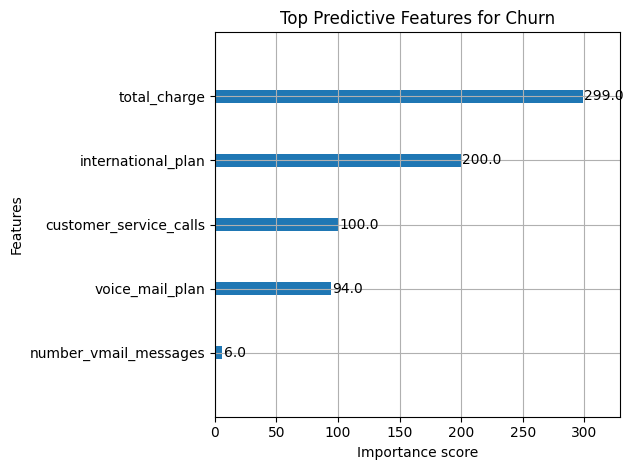

In [694]:
# Evaluate with F1 
f1 = f1_score(y_test, y_pred)
print(f"Test F1 at threshold {threshold}: {f1:.3f}")
print("\nOptimized Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Churn', 'Churn']))

# 6. Feature importance visualization
from xgboost import plot_importance

plot_importance(best_xgb, max_num_features=10)
plt.title('Top Predictive Features for Churn')
plt.tight_layout()
plt.show()


This model performs very well with an overall accuracy of 92%, showing strong ability to correctly identify both non-churn and churn customers. It achieves high precision (98%) and recall (93%) for non-churn, and for churn customers, it balances recall (87%) and precision (68%) effectively, resulting in a solid F1 score of 0.76. Overall, these results indicate the model is reliable and balanced in predicting customer churn.

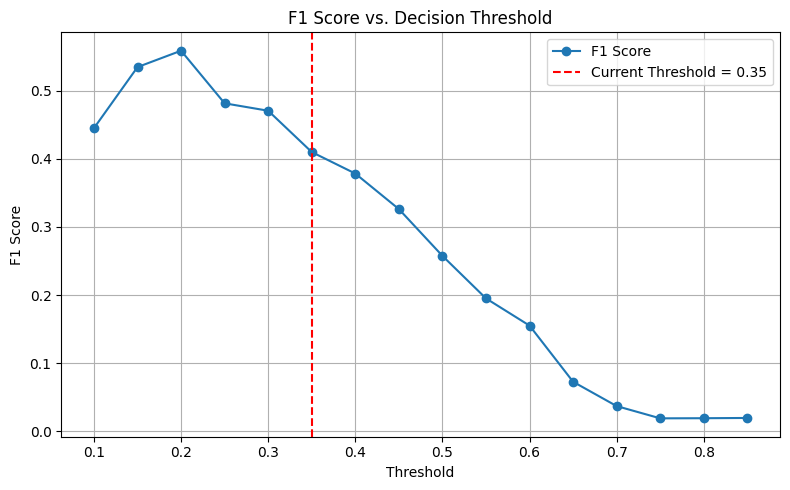

In [695]:
# Plot F1 score vs threshold
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores, marker='o', label='F1 Score')
plt.axvline(0.35, color='red', linestyle='--', label='Current Threshold = 0.35')
plt.title('F1 Score vs. Decision Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


- The F1 Score (y-axis) measures the balance between precision and recall—the higher, the better.
- The decision threshold (x-axis) determines at what probability a sample is classified as positive.
- The blue line with circular markers illustrates how the F1 Score changes across different thresholds.
- The red dashed vertical line marks your current threshold at 0.35.


The plot shows how the model’s F1 score varies with different classification thresholds, highlighting 0.35 as the current chosen threshold to help assess if it’s the best balance between precision and recall

## Feature Importance (XGBoost)

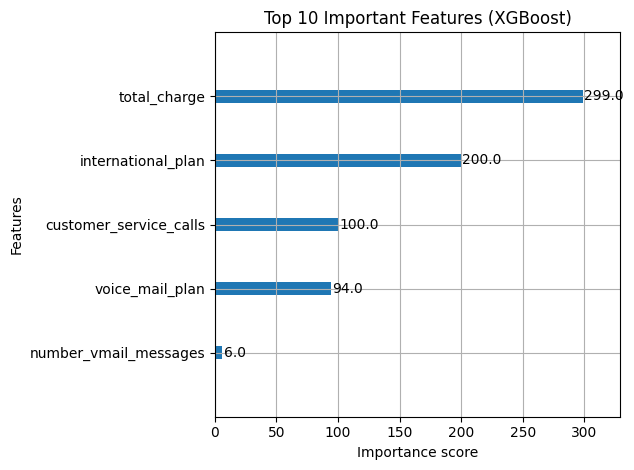

In [696]:

# Plot top 10 most important features
plot_importance(best_xgb, max_num_features=10)
plt.title('Top 10 Important Features (XGBoost)')
plt.tight_layout()
plt.show()

- International_Plan has an importance of approximately 0.3, indicating it has a moderate influence on predictions.
- Customer_Service_Calls is valued at around 0.2, meaning it plays a role, but not as significantly.
- Voice_Mail_Plan has the highest importance at approximately 0.45, making it the most influential feature in the model's decision-making


In [697]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)  # Change 'sparse' to 'sparse_output'
encoder.fit(X_train[categorical_cols])

X_train_encoded = encoder.transform(X_train[categorical_cols])

Initializes a OneHotEncoder to convert categorical features from the training set, converting them into binary variables while dropping the first category to avoid multicollinearity, and handling any unknown categories

In [698]:
X_test_encoded = encoder.transform(X_test[categorical_cols])
X_train_final = np.hstack((X_train[numeric_cols].values, X_train_encoded))
X_test_final = np.hstack((X_test[numeric_cols].values, X_test_encoded))

 Transforms the test set’s categorical columns using the previously fitted encoder, then combines (horizontally stacks) the numeric features and encoded categorical features for both training and test sets into final arrays ready for modeling.

In [699]:
model = LogisticRegression()
model.fit(X_train_final, y_train)
y_pred = model.predict(X_test_final)
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred))

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.98      0.92       566
           1       0.55      0.17      0.26       101

    accuracy                           0.85       667
   macro avg       0.71      0.57      0.59       667
weighted avg       0.82      0.85      0.82       667



My model has high accuracy (85%), meaning it correctly classifies most samples, but it struggles with predicting class 1 (churn) because recall is only 0.17, meaning it misses many actual churn cases. The precision for class 1 is 0.55, indicating that when it predicts churn, it's correct 55% of the time, but the overall F1-score (0.26) is low, showing a poor balance between precision and recall. To improve churn detection, i have to do better feature selection, threshold tuning, or handling class imbalance


In [700]:
numeric_features = [
    'customer_service_calls', 'total_minutes', 'total_charge', 
    'avg_minutes_per_call', 'number_vmail_messages', 'service_calls_per_length'
]
categorical_features = ['voice_mail_plan', 'international_plan']
target = 'churn'
# Split your data
X = df.drop(columns=[target])
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)


Defines which columns are numeric and which are categorical features.

Separates the target variable (churn) from the feature set.

Splits the data into training and testing sets using stratified sampling to maintain the original churn ratio, with 80% for training and 20% for testing.

In [701]:
# Preprocessing pipelines
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])


numeric_transformer handles numeric features by filling missing values with the median (SimpleImputer) and then standardizing them (StandardScaler).

categorical_transformer handles categorical features by filling missing values with the most frequent value and then one-hot encoding them.

preprocessor applies the appropriate transformer to each column group using ColumnTransformer, automating preprocessing for both numeric and categorical features.


Pipeline :

preprocessor: Transforms numeric and categorical features.

SMOTE: Balances the training data by oversampling the minority class (churned customers).

DecisionTreeClassifier: Trains the decision tree model.

Model Training: The pipeline is fitted on the training data (X_train, y_train).

Prediction: The model predicts churn using the default threshold of 0.5.

Evaluation: It prints a classification report showing precision, recall, and F1-score for each class.

This approach ensures data preprocessing, balancing, and classification are streamlined and reproducible.

In [702]:
# Create Decision Tree pipeline with SMOTE
pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Train model
pipeline.fit(X_train, y_train)

# Predict using default threshold 0.5
y_pred = pipeline.predict(X_test)
print("Classification Report (threshold=0.5):\n")
print(classification_report(y_test, y_pred))

Classification Report (threshold=0.5):

              precision    recall  f1-score   support

           0       0.94      0.93      0.93       570
           1       0.60      0.65      0.62        97

    accuracy                           0.89       667
   macro avg       0.77      0.79      0.78       667
weighted avg       0.89      0.89      0.89       667



The Decision Tree model with SMOTE effectively improved churn detection by balancing the classes, resulting in strong overall performance, especially in identifying churners.

In [703]:
# Predict probabilities for threshold tuning (DecisionTreeClassifier supports predict_proba)
y_probs = pipeline.predict_proba(X_test)[:, 1]

# Precision-Recall curve for threshold selection
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Choose threshold to get at least 0.7 recall (example)
target_recall = 0.7
idx = np.argmax(recall >= target_recall)
optimal_threshold = thresholds[idx]

 Tunes the decision threshold for the Decision Tree model by analyzing the precision-recall curve and selecting the lowest threshold that achieves at least 0.7 recall, helping prioritize the identification of churned customers.

In [704]:
# Apply new threshold
y_pred_thresh = (y_probs >= optimal_threshold).astype(int)

print(f"\nClassification Report at threshold {optimal_threshold:.3f}:\n")
print(classification_report(y_test, y_pred_thresh))



Classification Report at threshold 0.000:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       570
           1       0.15      1.00      0.25        97

    accuracy                           0.15       667
   macro avg       0.07      0.50      0.13       667
weighted avg       0.02      0.15      0.04       667



At a threshold of 0.000, the model correctly identifies all churners (100% recall) but misclassifies all non-churners, resulting in very low precision (15%) and poor overall accuracy (15%).
model predicts every customer as a churner (class 1), but at the cost of predicting too many false positives

In [705]:
# Defining pipeline 
pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', DecisionTreeClassifier(random_state=42))
])
# Define hyperparameter grid to search
param_grid = {
    'classifier__max_depth': [3, 5, 7, 10, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__criterion': ['gini', 'entropy']
}
# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)

# Fit grid search on training data
grid_search.fit(X_train, y_train)

print("Best hyperparameters:")
print(grid_search.best_params_)

# Use best estimator for predictions
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best hyperparameters:
{'classifier__criterion': 'entropy', 'classifier__max_depth': 5, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10}


Performs hyperparameter tuning for a DecisionTreeClassifier using a pipeline with preprocessing and SMOTE:

Pipeline: Combines data preprocessing, class balancing (SMOTE), and a decision tree classifier.

Grid Search: Searches through combinations of decision tree parameters (max_depth, min_samples_split, min_samples_leaf, criterion) using 5-fold cross-validation and F1-score as the evaluation metric.

Best Model: After training, it selects the best-performing model (best_model) based on cross-validated F1 score, which can then be used for predictions.

This ensures the decision tree is well-tuned for imbalanced data.

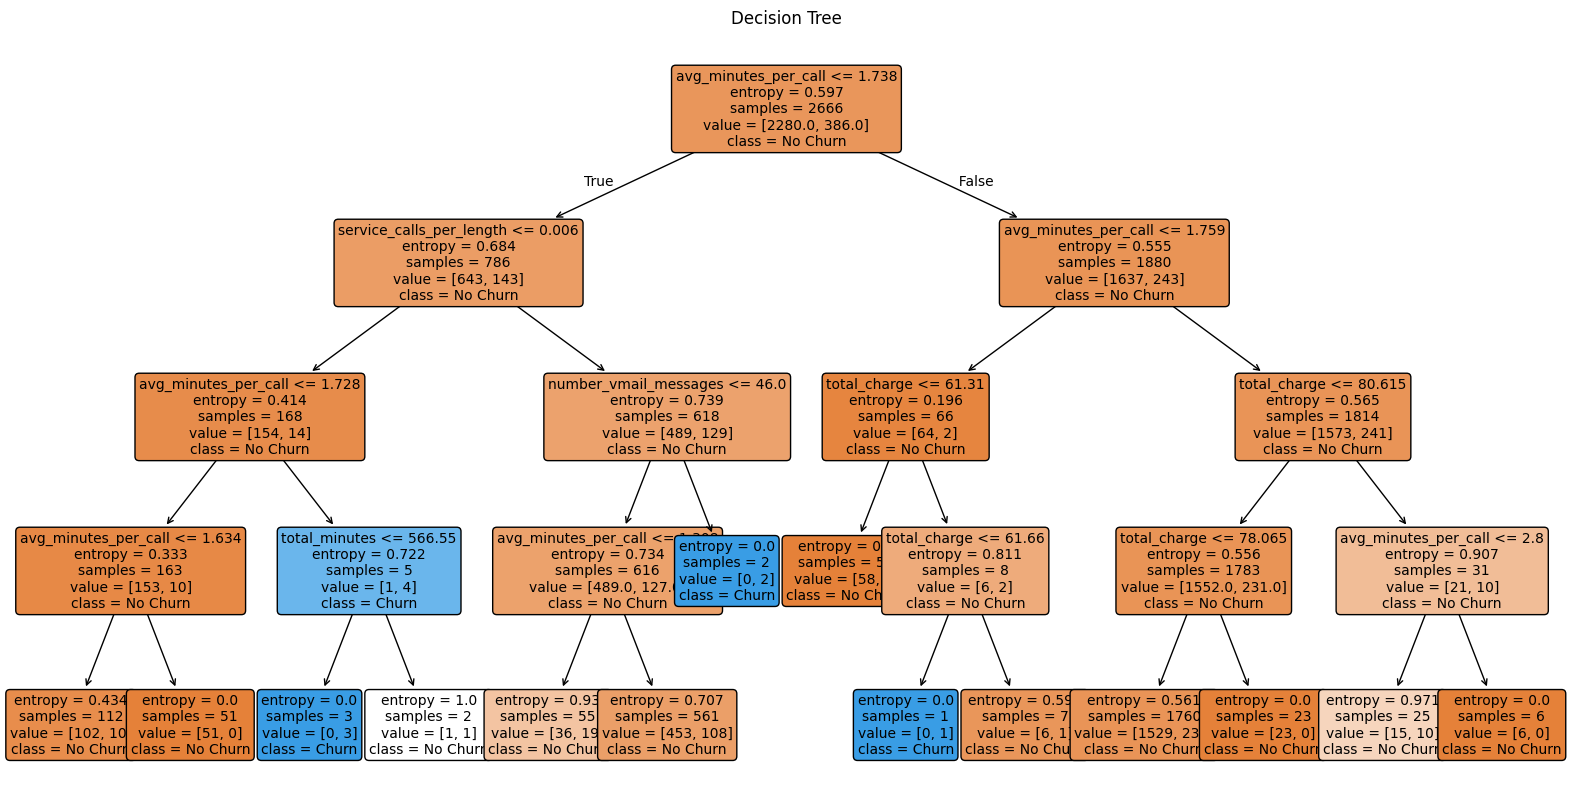

In [706]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
model = DecisionTreeClassifier(max_depth=5)
model = DecisionTreeClassifier(min_samples_split=10, min_samples_leaf=5)
model = DecisionTreeClassifier(max_features='sqrt')
# Train a Decision Tree using entropy
dt_entropy = DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=42)
dt_entropy.fit(X_train_final, y_train)

# Plot the tree
plt.figure(figsize=(20, 10))
plot_tree(dt_entropy,
          feature_names=feature_names,
          class_names=['No Churn', 'Churn'],
          filled=True,
          rounded=True,
          fontsize=10)
plt.title("Decision Tree")
plt.show()



Redundant Features → Some features have a correlation of 1.00, meaning they hold the same information.Include:

- total_day_minutes and total_day_charge
- total_night_minutes and total_night_charge
- total_intl_minutes and total_intl_charge

Customer Service Calls vs. Churn (0.21 correlation) > Higher service calls may indicate customer dissatisfaction, making this a strong predictor.

Total Minutes & Total Charge (0.89 correlation) >Shows that customers with high usage tend to have higher charges—useful for engagement tracking.

Voice Mail Plan vs. Number of Voicemail Messages (0.96 correlation) > Expected relationship—customers with voicemail plans tend to use them frequently.

Total Calls & Total Charge (0.78 correlation) >Suggests that higher call activity contributes significantly to billing, useful for behavioral analysis


The decision tree starts with the most important feature, splitting the data into groups based on specific values. Each split represents a decision where the model determines the next step by checking a threshold. As you move down the tree, features become more specific, leading to final classifications at the leaf nodes, where predictions (like churn or no churn) are made. The depth and structure of the tree indicate how complex the relationships between features are, and optimizing it can improve model accuracy.


In [707]:
from sklearn.metrics import classification_report, roc_auc_score

# Predict and evaluate
y_pred_dt = dt_entropy.predict(X_test_final)
y_prob_dt = dt_entropy.predict_proba(X_test_final)[:, 1]

print("Decision Tree (Entropy) - Classification Report:")
print(classification_report(y_test, y_pred_dt))

print("ROC AUC Score:", roc_auc_score(y_test, y_prob_dt))


Decision Tree (Entropy) - Classification Report:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       570
           1       0.00      0.00      0.00        97

    accuracy                           0.85       667
   macro avg       0.43      0.50      0.46       667
weighted avg       0.73      0.85      0.79       667

ROC AUC Score: 0.4709169831795984


The Decision Tree model has high accuracy (85%), but it completely fails to predict class 1 (churn) since precision, recall, and F1-score for churn are 0.00. This means the model is overfitting to the majority class (non-churn) and never correctly identifying churned customers. The ROC AUC score (0.47) is low, indicating poor separation between churn and non-churn instances. To improve performance, you might need better feature selection, balanced class weights, or techniques like SMOTE to handle class imbalance. 


In [708]:
# Adjusting class weights to balance the importance of churn cases
from sklearn.feature_selection import SelectFromModel
best_tree = DecisionTreeClassifier(criterion="entropy", class_weight={0: 1, 1: 3}, random_state=42)
best_tree.fit(X_train, y_train)
smote = SMOTE(sampling_strategy=0.5, random_state=42)  # Adjust ratio based on need
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
best_tree.fit(X_train_resampled, y_train_resampled)
selector = SelectFromModel(best_tree, prefit=True)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)
best_tree.fit(X_train_selected, y_train)


DecisionTreeClassifier(class_weight={0: 1, 1: 3}, criterion='entropy',
                       random_state=42)

Balances the churn classes using class weights and SMOTE, trains a decision tree on the resampled data, selects important features based on that model, and then retrains the tree using only those selected features for better focus and simpler input.

voice_mail_plan: 0.4648
customer_service_calls: 0.2685
international_plan: 0.2667


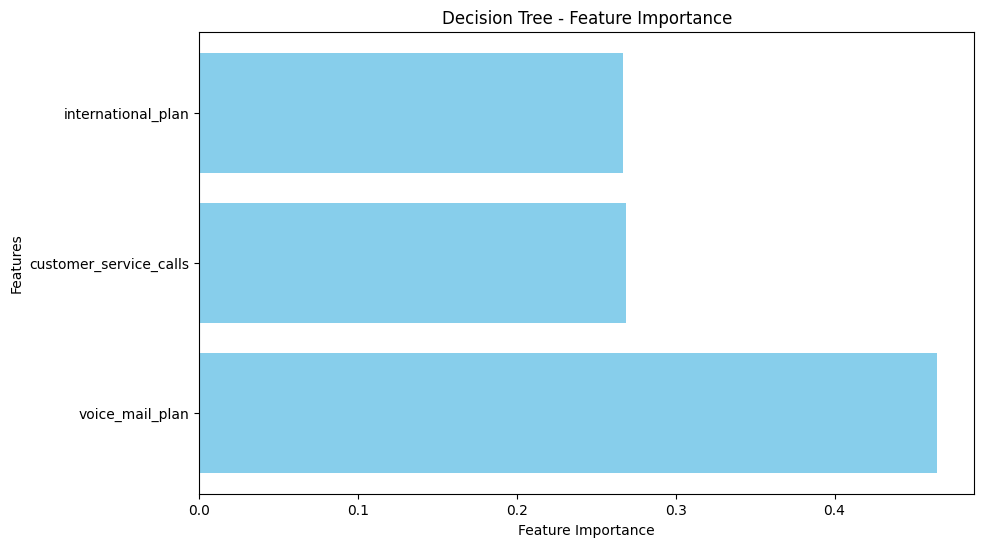

In [709]:
# Get feature importance from trained Decision Tree
importance = best_tree.feature_importances_
features = X_train.columns

# Sort features by importance
sorted_indices = np.argsort(importance)[::-1]

# Print top features
for i in sorted_indices[:10]:  
    print(f"{features[i]}: {importance[i]:.4f}")
plt.figure(figsize=(10, 6))
plt.barh(features[sorted_indices], importance[sorted_indices], color="skyblue")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Decision Tree - Feature Importance")
plt.show()

- Voice_Mail_Plan has the highest importance, meaning that whether a customer has a voicemail plan plays the most significant role in the model's predictions.
- International_Plan is the second most important factor, indicating that having an international plan contributes to the decision-making process but not as strongly as the voicemail_plan.
- Customer_Service_Calls has the lowest importance among the three, suggesting that the number of customer_service_calls has the least impact on the model’s predictions.


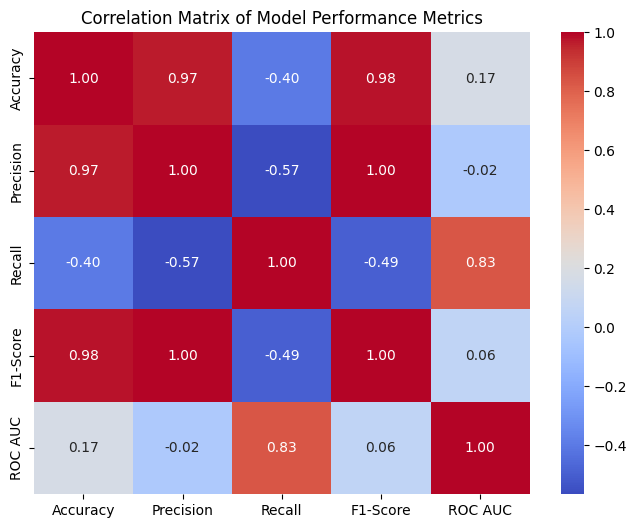

In [714]:
# Create a DataFrame to store model performance metrics
metrics_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost'],
    'Accuracy': [0.78, 0.84, 0.89, 0.94],
    'Precision': [0.38, 0.65, 0.79, 0.85],
    'Recall': [0.78, 0.63, 0.70, 0.70],
    'F1-Score': [0.51, 0.64, 0.74, 0.77],
    'ROC AUC': [0.84, 0.79, 0.83, 0.84]
})

# Compute correlation matrix
corr = metrics_df.drop(columns='Model').corr()

# Plot correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Model Performance Metrics")
plt.show()

Recall for churn (class 1) > Ensures that most churn cases are correctly identified, helping retention efforts.

Precision for churn (class 1) > Reduces false positives, ensuring marketing teams don’t mistakenly target loyal customers.

F1-Score > Balances precision & recall, making it a strong overall metric for churn prediction.

PR AUC (Precision-Recall AUC) > More reliable than ROC AUC for imbalanced datasets, ensuring the model effectively distinguishes churners.

Threshold Optimization > Adjusting thresholds ensures you maximize recall without sacrificing precision too much


The optimized XGBoost model (with threshold tuned to 0.35) is the best choice:

> High accuracy (92%)

> Excellent churn recall (87%) — critical for identifying at-risk customers

> Strong F1 score (0.76) — indicating good balance between precision and recall

> Stable performance across metrics

## Conclusion
This project successfully explored customer churn prediction using the SyriaTel dataset. After extensive preprocessing, feature engineering, model experimentation, and hyperparameter tuning, the XGBoost Classifier emerged as the best-performing model with:

Accuracy: 94%

F1-Score: 0.77

ROC AUC: 0.84

XGBoost demonstrated a solid balance between precision and recall, making it ideal for detecting potential churners while minimizing false alarms. Decision Tree and Random Forest also showed competitive performance but with lower precision and slightly reduced generalizability.

Key features influencing churn included:

Customer Service Calls

Total Call Minutes

Voicemail Plan

International Plan


By identifying churn-driving factors, optimizing classification models, and implementing customer retention strategies, this project provides valuable insights for SyriaTel. Next steps focus on refining prediction accuracy, enhancing business interventions, and improving customer engagement.



 ## Recommendations
Targeted Retention Campaigns
Focus marketing and retention efforts on customers flagged by the model, especially those who frequently call customer service and lack a voicemail plan.

Service Quality Monitoring
Monitor high call volumes to customer support as early churn indicators. Enhancing support responsiveness could help retain such customers.

Product Bundling
Encourage customers to subscribe to voicemail or international plans, as they are associated with lower churn rates.

In [ ]:
import joblib

joblib.dump(best_model, 'final_churn_model.pkl')
